In this notebook, we will use _Tunax_ to calibrate a subset of the parameters of the closure $k-\varepsilon$ using a subset of the database of LES that Gregory Wagner used in his paper on the calibration of the closure CATKE [1]. The subset of parameters that we will calibrate are the ones which influence the equation of $\varepsilon$. They are noted as $c_{\varepsilon_1}, c_{\varepsilon_2}, c_{\varepsilon_3^-}$ and $c_{\varepsilon_3^+}$ in [2]. The subset of the LES that we will use is the 7 simulations in the condition of free-convection.

# Database
The 7 LES that we will use are extracted from the database of Wagner [1]. These simulations all have a space resolution of 1m. These simulations are done on 7 different timeframe with 7 different forcing so that for each one the mixing length is about 100m at the end of the simulation.

### Visualisation of one simulation
One can choose in the code below the simulation of the set of Wagner to visualize.

In [6]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

timeframe_list = [6, 12, 18, 24, 36, 48, 72]
space_step_list = [0.75, 1, 2, 4]
forcing_list = ['free_convection', 'med_wind_med_cooling', 'strong_wind', 'strong_wind_no_rotation', 'strong_wind_weak_cooling', 'weak_wind_strong_cooling']

timeframe = timeframe_list[1]
space_step = space_step_list[1]
forcing = forcing_list[0]
filename = os.path.join('..', 'obs', 'horizontally_averaged_LES_data', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
filename_yaml = os.path.join('..', 'obs', 'horizontally_averaged_LES_data', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

if os.path.exists(filename):
    ds = xr.open_dataset(filename)
else:
    print("simulation doesn't exit")
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (t: 73, zw: 257, zr: 256)
Coordinates:
  * t        (t) float64 584B 0.0 600.0 1.2e+03 ... 4.2e+04 4.26e+04 4.32e+04
  * zw       (zw) float64 2kB -256.0 -253.7 -251.4 -249.2 ... -1.539 -0.7697 0.0
  * zr       (zr) float64 2kB -254.9 -252.6 -250.3 ... -1.924 -1.155 -0.3848
Data variables: (12/25)
    Ri       (t, zw) float64 150kB ...
    T        (t, zr) float64 150kB ...
    TT       (t, zr) float64 150kB ...
    b        (t, zr) float64 150kB ...
    bT       (t, zr) float64 150kB ...
    e        (t, zr) float64 150kB ...
    ...       ...
    wv       (t, zw) float64 150kB ...
    ww       (t, zw) float64 150kB ...
    KdzT     (t, zw) float64 150kB ...
    mudzu    (t, zw) float64 150kB ...
    mudzv    (t, zw) float64 150kB ...
    mudzw    (t, zr) float64 150kB ...

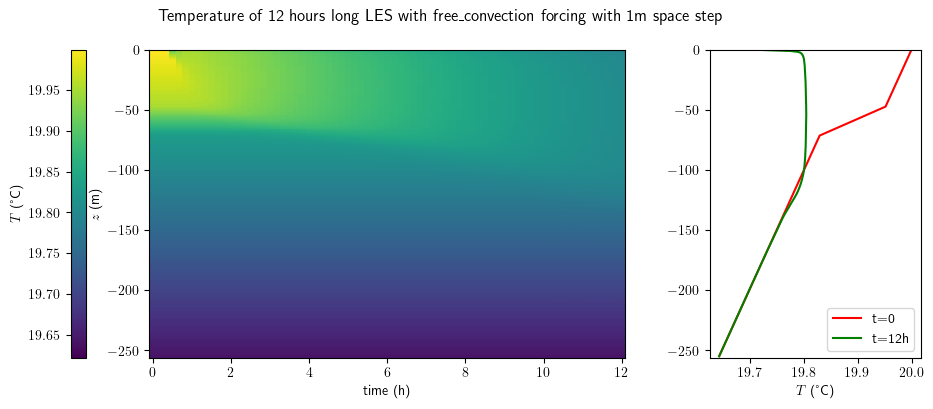

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True)

time = ds.t/3600
X, Y = np.meshgrid(time, ds.zr)

fig = plt.figure(figsize=(12, 4))
plt.tight_layout()
[gs_2D, gs_1D] = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax_2D = fig.add_subplot(gs_2D)
ax_1D = fig.add_subplot(gs_1D, sharey=ax_2D)

pcm = ax_2D.pcolormesh(X, Y, ds.T.transpose(), shading='nearest')
fig.colorbar(pcm, ax=ax_2D, label='$T$ (°C)', location='left')
ax_2D.set_xlabel('time (h)')
ax_2D.set_ylabel('$z$ (m)')

ax_1D.plot(ds.T[0, :], ds.zr, 'r', label='t=0')
ax_1D.plot(ds.T[-1, :], ds.zr, 'g', label=f't={int(time[-1])}h')
ax_1D.set_xlabel('$T$ (°C)')
ax_1D.legend()

fig.suptitle(f'Temperature of {timeframe} hours long LES with {forcing} forcing with {space_step}m space step')
plt.show()

### Visualization of all the simulations
Here we can visualize all the simulations in free-convection.

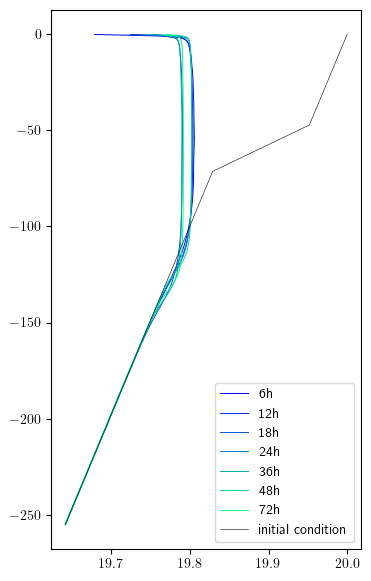

In [11]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(4, 7))
colors = cm.winter(np.linspace(0, 1, 7))
for i, timeframe in enumerate(timeframe_list):
    filename = os.path.join('..', 'obs', 'horizontally_averaged_LES_data', f'{timeframe}_hour_suite', '1m', 'free_convection_instantaneous_statistics.nc')
    ds = xr.open_dataset(filename)
    plt.plot(ds.T[-1, :], ds.zr, color=colors[i], linewidth=0.7, label=f'{timeframe}h')
plt.plot(ds.T[0, :], ds.zr, color='k', linewidth=0.4, label=f'initial condition')
plt.legend()

### Run SCM on the simulations
To chose a time step $\Delta t$ to run SCM on our simulations, we have to use a CFL condition.
$$a \dfrac {\Delta t}{\Delta x} \leqslant 1$$
where $a$ is the velocity of the information. For the free convection we take into acount the temparature, the maximum gradient temperature in the initial condition is about $\Delta T = 8\cdot 10^{-3} \, \text K \cdot \text m ^{-1}$ and the temparature flux forcing is at the maximum (for the shorter simulation) $f = 5\cdot 10^{-4} \, \text K \cdot \text m\cdot s^{-1}$. It makes a CFL condition with $a = \frac {\Delta T} f = 16 \, \text s$. If we take $\Delta t = 10 \, \text s$ and $\Delta x = 1 \, \text m$ the condition is validated.

In [65]:
import os
os.chdir('../src')
from database import Obs
import equinox as eqx
from model import SingleColumnModel
from closures.k_epsilon import KepsParameters


timeframe_list = [6, 12, 18, 24, 36, 48, 72]
space_step_list = [0.75, 1, 2, 4]
forcing_list = ['free_convection', 'med_wind_med_cooling', 'strong_wind', 'strong_wind_no_rotation', 'strong_wind_weak_cooling', 'weak_wind_strong_cooling']


var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': '',
    'u': 'u',
    'v': 'v',
    'grav': 'gravitational_acceleration',
    'alpha': 'thermal_expansion',
    'beta': 'haline_contraction',
    'tflx_sfc': 'temperature_flux',
    'fcor': 'Coriolis',
    'ustr_sfc': 'momentum_flux'
}

traj_wagner_list = []
traj_scm_list = []
for forcing in forcing_list:
    space_step = space_step_list[1]
    timeframe = timeframe_list[0]
    filename = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
    filename_yaml = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

    obs = Obs.from_files(filename, filename_yaml, var_names)
    traj_wagner = obs.trajectory

    # inversion du flux
    obs = eqx.tree_at(lambda t: t.case.tflx_sfc, obs, -obs.case.tflx_sfc)
    obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.case.ustr_sfc)

    time_frame = float(traj_wagner.time[-1]/3600)
    dt = 10.
    out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
    init_state = traj_wagner.extract_state(0)
    model = SingleColumnModel(time_frame, dt, out_dt, traj_wagner.grid, init_state, obs.case, 'k-epsilon')

    keps_params = KepsParameters()

    traj_scm = model.compute_trajectory_with(keps_params)

    traj_wagner_list.append(traj_wagner)
    traj_scm_list.append(traj_scm)


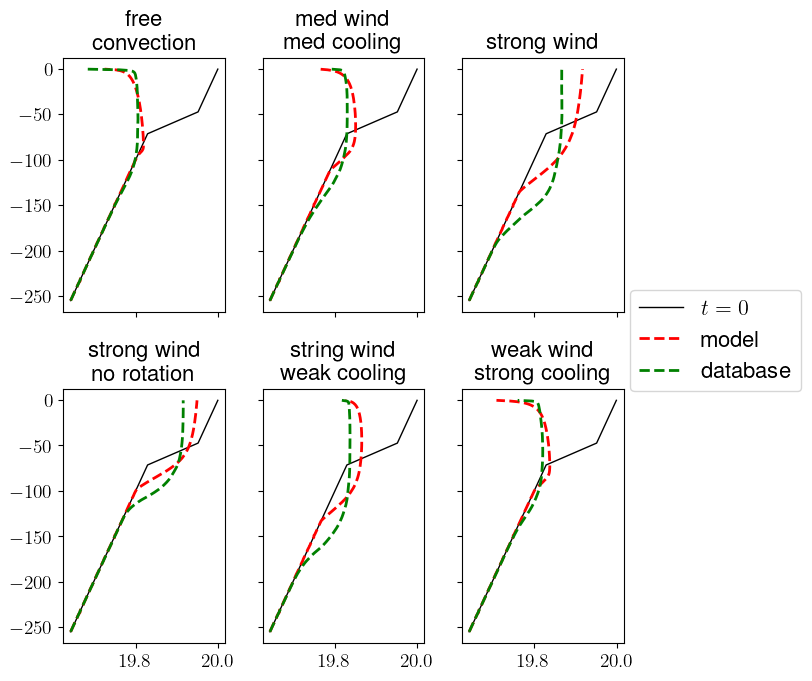

In [83]:
import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica', size=16)
zr = model.grid.zr
cm_inch = 0.394
liste_titres = ['free\nconvection', 'med wind\nmed cooling', 'strong wind', 'strong wind\nno rotation', 'string wind\nweak cooling', 'weak wind\nstrong cooling']
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(21*cm_inch, 18*cm_inch))
# plt.tight_layout(rect=[0., 0., 0.1, 0.1])
plt.xticks(fontsize=16)

axes_list = []
for axes_line in axes:
    for ax in axes_line:
        axes_list.append(ax)

for i_ax, ax in enumerate(axes_list):
    ax.set_title(liste_titres[i_ax], fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    traj_scm = traj_scm_list[i_ax]
    traj_wagner = traj_wagner_list[i_ax]
    l_i, = ax.plot(traj_scm.t[0, :], zr, 'k', linewidth=1)
    l_s, = ax.plot(traj_scm.t[-1, :], zr, 'r--', linewidth=2)
    l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'g--', linewidth=2)
    if i_ax == 0:
        l_i.set_label('$t = 0$')
        l_s.set_label(r'model')
        l_w.set_label(r'database')

plt.tight_layout(rect=[0, 0, 0.81, 1])
fig.legend(loc='right', ncol=1, fontsize=16)

plt.show()


fig.savefig("wagner_vs_scm.pdf", dpi=300, transparent=True)

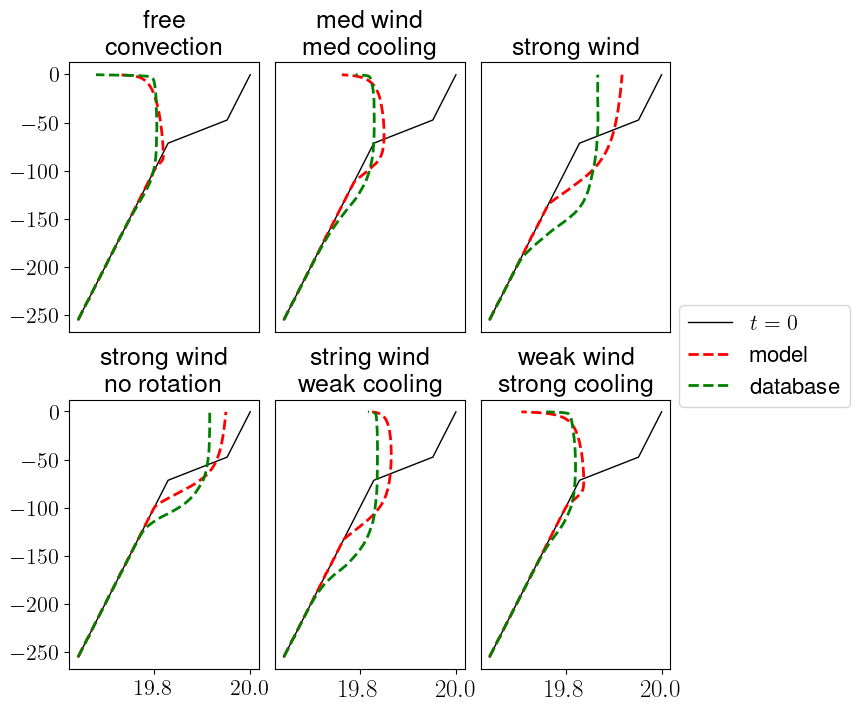

In [66]:
import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica', size=18)
zr = model.grid.zr
cm_inch = 0.394
liste_titres = ['free\nconvection', 'med wind\nmed cooling', 'strong wind', 'strong wind\nno rotation', 'string wind\nweak cooling', 'weak wind\nstrong cooling']
fig, axes = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(23*cm_inch, 20*cm_inch), width_ratios=[1, 1, 1, 0.45])

plt.subplots_adjust(hspace=0.25, wspace=0.1)
# plt.tight_layout(rect=[0., 0., 0.1, 0.1])
plt.xticks(fontsize=16)

axes_list = []
for axes_line in axes:
    for ax in axes_line[:-1]:
        axes_list.append(ax)
    axes_line[-1].axis('off')
    axes_line[0].tick_params(axis='both', labelsize=16)
    axes_line[1].tick_params(left=False)
    axes_line[2].tick_params(left=False)
axes[0][0].tick_params(bottom=False)
axes[0][1].tick_params(bottom=False)
axes[0][2].tick_params(bottom=False)

for i_ax, ax in enumerate(axes_list):
    ax.set_title(liste_titres[i_ax], fontsize=18)
    traj_scm = traj_scm_list[i_ax]
    traj_wagner = traj_wagner_list[i_ax]
    l_i, = ax.plot(traj_scm.t[0, :], zr, 'k', linewidth=1)
    l_s, = ax.plot(traj_scm.t[-1, :], zr, 'r--', linewidth=2)
    l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'g--', linewidth=2)
    if i_ax == 0:
        l_i.set_label('$t = 0$')
        l_s.set_label(r'model')
        l_w.set_label(r'database')

# plt.tight_layout()

fig.legend(loc='right', ncol=1, fontsize=16)

plt.show()


fig.savefig("wagner_vs_scm.png", dpi=300, transparent=True)

# Fit on one simulations
We notice that the shorter simulation is the one with the highest difference between the moel and the LES simulation, probably because it's the simulation with the highest forcing. For a first try of calibration, we will use only this one.

In [1]:
import os
import equinox as eqx
import jax.numpy as jnp

os.chdir('../src')
from database import Obs, ObsSet
from fitter import FittableParameter, FittableParametersSet
from typing import List
from state import Trajectory

var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': '',
    'u': 'u',
    'v': 'v',
    'grav': 'gravitational_acceleration',
    'alpha': 'thermal_expansion',
    'beta': 'haline_contraction',
    'tflx_sfc': 'temperature_flux',
    'fcor': 'Coriolis',
    'ustr_sfc': 'momentum_flux'
}

timeframe = 6
space_step = 1
forcing = 'free_convection'
filename = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
filename_yaml = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

obs = Obs.from_files(filename, filename_yaml, var_names)

# inversion du flux
obs: Obs = eqx.tree_at(lambda t: t.case.tflx_sfc, obs, -obs.case.tflx_sfc)
obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.case.ustr_sfc)

obs_set = ObsSet([obs])
c_eps1_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.44)
c_eps2_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.92)
c_eps3m_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=.4)
c_eps3p_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.)
c1_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=5.)
c2_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=.8)
c3_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.968)
c4_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.136)
c6_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=.4)
cb1_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=5.95)
cb2_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=.6)
cb3_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.)
cb5_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=.3333)
cbb_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=.72)
# c_mu0_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=0.5477)
# sig_k_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.)
# sig_eps_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=1.3)
coef_dico = {
    'c_eps1': c_eps1_par,
    'c_eps2': c_eps2_par,
    'c_eps3m': c_eps3m_par,
    'c_eps3p': c_eps3p_par,
    'c1': c1_par,
    'c2': c2_par,
    'c3': c3_par,
    'c4': c4_par,
    'c6': c6_par,
    'cb1': cb1_par,
    'cb2': cb2_par,
    'cb3': cb3_par,
    'cb5': cb5_par,
    'cbb': cbb_par
    # 'c_mu0': c_mu0_par,
    # 'sig_k': sig_k_par,
    # 'sig_eps': sig_eps_par
}
coef_fit_params = FittableParametersSet(coef_dico, 'k-epsilon')

def loss(scm_set: List[Trajectory], obs_set: ObsSet):
    obs = obs_set.observations[0]
    t_obs = obs.trajectory.t
    t_scm = scm_set[0].t
    return jnp.sum((t_scm-t_obs)**2)

from fitter import Fitter
nloop = 200
learning_rate = 1
dt =10.
verbatim = True
f = Fitter(coef_fit_params, obs_set, loss, nloop, learning_rate, verbatim, dt, 'k-epsilon')
x, x_history, grads_history = f()


/Users/admin-mouttaga/Codes/tunax/src/model.py:113: UserWarning: The `time_frame`is not proportional to the out time-step `out_dt`, the last step will be computed a few before the `time_frame`.
  warnings.warn(format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/src/model.py:119: UserWarning: The `time_frame`is not proportional to the time-step `dt`, the last step will be computed a few before the time_frame.
  warnings.warn(format_to_single_line("""



                    loop 0
                    x [ 1.4400001e+00  2.9199934e+00  1.3999816e+00  6.6161156e-06
  5.9999933e+00  1.7999934e+00  2.9679930e+00  2.1359935e+00
  1.3999932e+00  4.9500065e+00  1.5999930e+00  1.9999930e+00
 -6.6669339e-01  1.7199934e+00]
                    grads [ 0.         -0.40453702 -0.00086174  0.63032347 -0.11338537 -0.8089674
 -0.02856172 -0.08568516 -0.10088832  0.1170565  -0.03600217 -0.03600217
  0.3391804  -0.31407163]
                

                    loop 1
                    x [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
                    grads [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
                

                    loop 2
                    x [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
                    grads [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
                

                    loop 3
                    x [nan nan nan nan nan nan nan nan nan nan nan nan nan 

In [2]:
import numpy as np
np.save('../notebooks/fit_wagner_n/c_eps1.npy', np.array([float(x_i [0]) for x_i in x_history]))
np.save('../notebooks/fit_wagner_n/c_eps2.npy', np.array([float(x_i [1]) for x_i in x_history]))
np.save('../notebooks/fit_wagner_n/c_eps3m.npy', np.array([float(x_i [2]) for x_i in x_history]))
np.save('../notebooks/fit_wagner_n/c_eps3p.npy', np.array([float(x_i [3]) for x_i in x_history]))
np.save('../notebooks/fit_wagner_n/grad_c_eps1.npy', np.array([float(g_i [0]) for g_i in grads_history]))
np.save('../notebooks/fit_wagner_n/grad_c_eps2.npy', np.array([float(g_i [1]) for g_i in grads_history]))
np.save('../notebooks/fit_wagner_n/grad_c_eps3m.npy', np.array([float(g_i [2]) for g_i in grads_history]))
np.save('../notebooks/fit_wagner_n/grad_c_eps3p.npy', np.array([float(g_i [3]) for g_i in grads_history]))

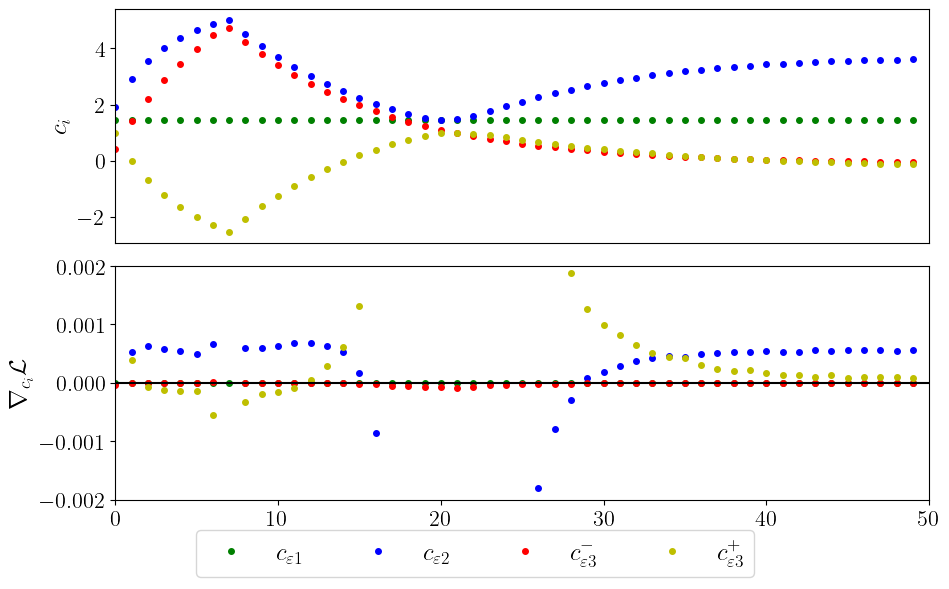

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica', size=18)
cm_inch = 0.394

c_eps1 = np.load('../notebooks/fit_wagner_n/c_eps1.npy')
c_eps2 = np.load('../notebooks/fit_wagner_n/c_eps2.npy')
c_eps3m = np.load('../notebooks/fit_wagner_n/c_eps3m.npy')
c_eps3p = np.load('../notebooks/fit_wagner_n/c_eps3p.npy')
grad_c_eps1 = np.load('../notebooks/fit_wagner_n/grad_c_eps1.npy')
grad_c_eps2 = np.load('../notebooks/fit_wagner_n/grad_c_eps2.npy')
grad_c_eps3m = np.load('../notebooks/fit_wagner_n/grad_c_eps3m.npy')
grad_c_eps3p = np.load('../notebooks/fit_wagner_n/grad_c_eps3p.npy')

fig, [ax_x, ax_g] = plt.subplots(2, 1, sharex=True, figsize=(24*cm_inch, 15*cm_inch), )
# plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0.07, 0.1, 1, 1.], pad=0.0)

ax_x.plot(c_eps1, 'g.', label=r'$c_{\varepsilon 1}$', markersize=8)
ax_x.plot(c_eps2, 'b.', label=r'$c_{\varepsilon 2}$', markersize=8)
ax_x.plot(c_eps3m, 'r.', label=r'$c_{\varepsilon 3}^-$', markersize=8)
ax_x.plot(c_eps3p, 'y.', label=r'$c_{\varepsilon 3}^+$', markersize=8)
# ax_x.axhline([5], color='k', label='$c_1$ obj')
ax_g.plot(grad_c_eps1, 'g.', markersize=8)
ax_g.plot(grad_c_eps2, 'b.', markersize=8)
ax_g.plot(grad_c_eps3m, 'r.', markersize=8)
ax_g.plot(grad_c_eps3p, 'y.', markersize=8)
ax_g.axhline(0, color='k', markersize=8)
ax_x.set_ylabel(r'$c_i$', fontsize=18)
ax_x.tick_params(axis='both', labelsize=16)
ax_g.tick_params(axis='both', labelsize=16)
ax_x.tick_params(bottom=False)
ax_g.set_ylabel(r'$\nabla_{c_i} \mathcal L$', fontsize=18)
ax_g.set_ylim([-.002, .002])
ax_g.set_xlim([0, 50])


fig.legend(loc='lower center', ncol=4)
plt.show()

fig.savefig("calibration.png", dpi=300, transparent=True)



In [9]:
f'({c_eps1[0]}, {c_eps2[0]}, {c_eps3m[0]}, {c_eps3p[0]}) -> ({c_eps1[-1]}, {c_eps2[-1]}, {c_eps3m[-1]}, {c_eps3p[-1]})'

'(1.440000057220459, 1.9199999570846558, 0.4000000059604645, 1.0) -> (1.440000057220459, 3.6059176921844482, -0.04613007605075836, -0.1343209445476532)'

In [10]:
from closures.k_epsilon import KepsParameters
from model import SingleColumnModel
from database import Obs
import jax.numpy as jnp

timeframe = 6
space_step = 1
forcing = 'free_convection'
filename = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
filename_yaml = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

obs = Obs.from_files(filename, filename_yaml, var_names)
traj_wag = obs.trajectory

cost_list = []
for i_loop in range(50):#range(c_eps1.shape[0]):
    c_1 = c_eps1[i_loop]
    c_2 = c_eps2[i_loop]
    c_3m = c_eps3m[i_loop]
    c_3p = c_eps3p[i_loop]
    keps_params = KepsParameters(c_eps1=c_1, c_eps2=c_2, c_eps3m=c_3m, c_eps3p=c_3p)


    model = SingleColumnModel(6, 10., float(traj_wag.time[1]-traj_wag.time[0]), traj_wag.grid, traj_wag.extract_state(0), obs.case, 'k-epsilon')

    traj = model.compute_trajectory_with(keps_params)

    cost = jnp.sum((traj.t[-1, :] - traj_wag.t[-1, :])**2)

    cost_list.append(float(cost))

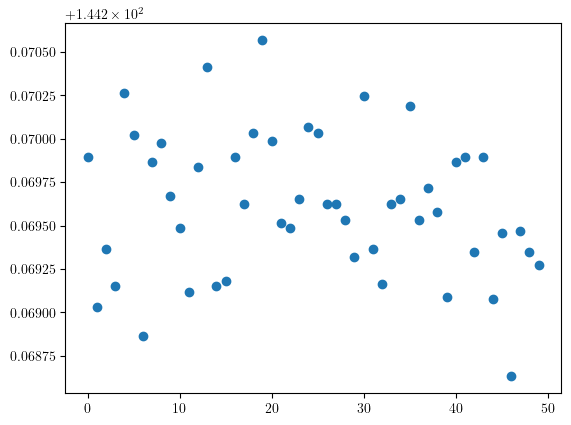

In [13]:
plt.plot(cost_list, 'o')


In [3]:
import os
os.chdir('../src')
from database import Obs
import equinox as eqx
from model import SingleColumnModel
from closures.k_epsilon import KepsParameters

var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': '',
    'u': 'u',
    'v': 'v',
    'grav': 'gravitational_acceleration',
    'alpha': 'thermal_expansion',
    'beta': 'haline_contraction',
    'tflx_sfc': 'temperature_flux',
    'fcor': 'Coriolis',
    'ustr_sfc': 'momentum_flux'
}

dt = 10.
space_step = 1
forcing = 'free_convection'
timeframe_list = [6, 12, 18, 24, 36, 48, 72]

traj_wagner_list = []
traj_scm_init_list = []
traj_scm_tuned_list = []
for timeframe in timeframe_list[:1]:
    print(timeframe)
    filename = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
    filename_yaml = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

    obs = Obs.from_files(filename, filename_yaml, var_names)
    traj_wagner = obs.trajectory

    # inversion du flux
    obs = eqx.tree_at(lambda t: t.case.tflx_sfc, obs, -obs.case.tflx_sfc)
    obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.case.ustr_sfc)

    # create model
    time_frame = float(traj_wagner.time[-1]/3600)
    out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
    init_state = traj_wagner.extract_state(0)
    model = SingleColumnModel(time_frame, dt, out_dt, traj_wagner.grid, init_state, obs.case, 'k-epsilon')

    # keps parameters
    keps_params_init = KepsParameters(c_eps1=c_eps1[0], c_eps2=c_eps2[0], c_eps3m=c_eps3m[0], c_eps3p=c_eps3p[0])

    keps_params_tuned = KepsParameters(c_eps1=c_eps1[-1], c_eps2=c_eps2[-1], c_eps3m=c_eps3m[-1], c_eps3p=c_eps3p[-1])

    # run models
    traj_scm_init = model.compute_trajectory_with(keps_params_init)
    traj_scm_tuned = model.compute_trajectory_with(keps_params_tuned)

    traj_wagner_list.append(traj_wagner)
    traj_scm_init_list.append(traj_scm_init)
    traj_scm_tuned_list.append(traj_scm_tuned)


6


IndexError: list index out of range

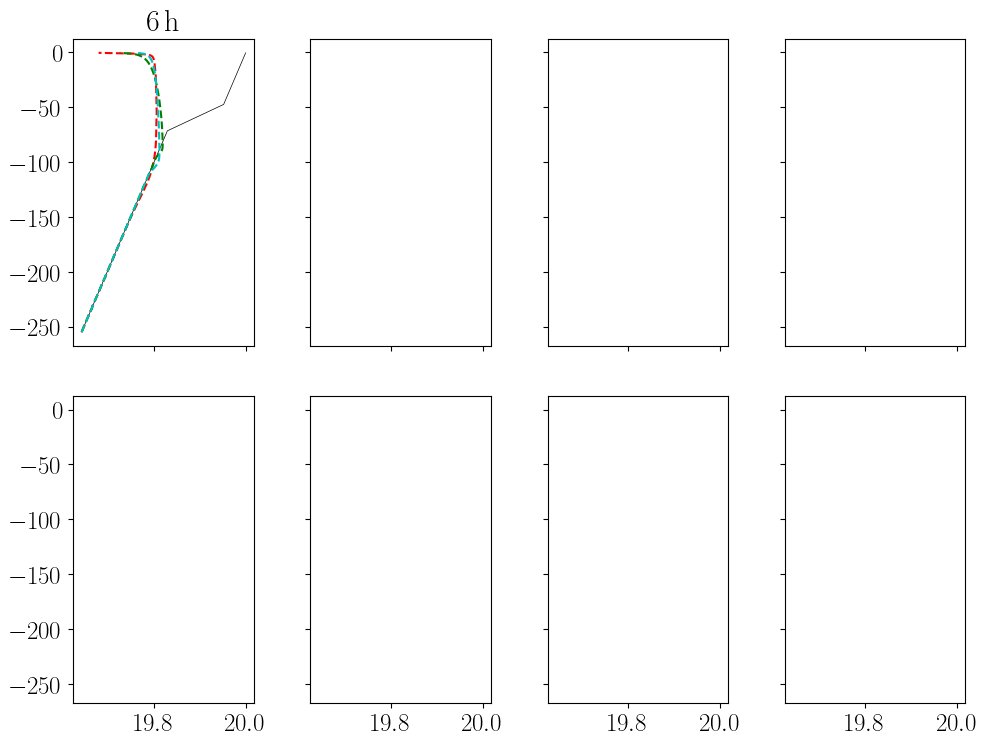

In [87]:
zr = model.grid.zr
plt.rc('text', usetex=True)

fig, axes = plt.subplots(2, 4, sharey=True, sharex=True,figsize=(10, 8))
plt.tight_layout(rect=[0., 0., 1., .95])

axes_list = []
for axes_line in axes:
    for ax in axes_line:
        axes_list.append(ax)

for i_ax, ax in enumerate(axes_list[:-1]):
    traj_wagner = traj_wagner_list[i_ax]
    traj_scm_init = traj_scm_init_list[i_ax]
    traj_scm_tuned = traj_scm_tuned_list[i_ax]
    l_i, = ax.plot(traj_wagner.t[0, :], zr, 'k', linewidth=0.5)
    l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'r--')
    l_si, = ax.plot(traj_scm_init.t[-1, :], zr, 'g--')
    l_st, = ax.plot(traj_scm_tuned.t[-1, :], zr, 'c--')
    ax.set_title(rf'${timeframe_list[i_ax]} \, \mathrm h$')
    
axes_list[0].set_xlim([19.7, 19.85])
axes_list[0].set_ylim([-150, 5])

axes_list[-1].legend([l_i, l_w, l_si, l_st], ['initial state', 'obs', 'before tuning', 'after tuning'], loc='center')
axes_list[-1].axis('off')

fig.suptitle('Tuning on Wagner free-convection database (zoom)')

plt.show()

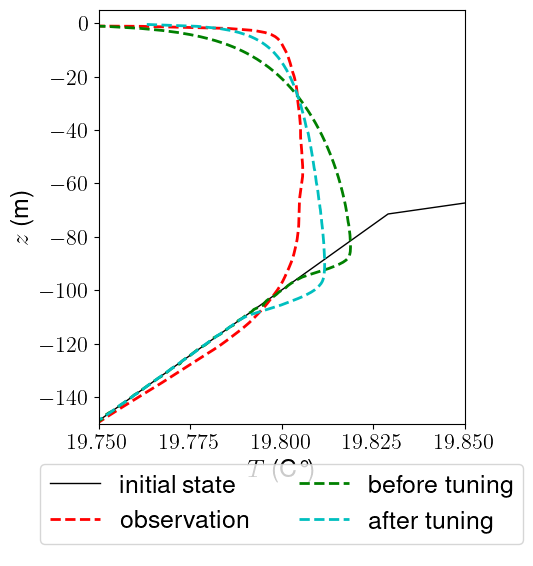

In [48]:

plt.rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica', size=18)

fig, [ax, ax_leg] = plt.subplots(2, 1, figsize=(12*cm_inch, 18*cm_inch), height_ratios=[1, 0.2])
# plt.tight_layout()
zr = model.grid.zr

ax_leg.axis('off')
traj_wagner = traj_wagner_list[0]
traj_scm_init = traj_scm_init_list[0]
traj_scm_tuned = traj_scm_tuned_list[0]
l_i, = ax.plot(traj_wagner.t[0, :], zr, 'k', linewidth=1)
l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'r--', linewidth=2)
l_si, = ax.plot(traj_scm_init.t[-1, :], zr, 'g--', linewidth=2)
l_st, = ax.plot(traj_scm_tuned.t[-1, :], zr, 'c--', linewidth=2)
ax.set_ylabel(r'$z$ (m)', fontsize=18)
ax.set_xlabel(r'$T$ (C°)', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='both', labelsize=16)
    
ax.set_xlim([19.75, 19.85])
ax.set_ylim([-150, 5])

ax_leg.legend([l_i, l_w, l_si, l_st], ['initial state', 'observation', 'before tuning', 'after tuning'], loc='lower center', ncol=2, fontsize=18)


plt.show()

fig.savefig("calibrated.pdf", dpi=300, transparent=True)


/var/folders/6k/3ycsgp4x75nc7_6w2cw9g5600000gr/T/ipykernel_42356/3582330000.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


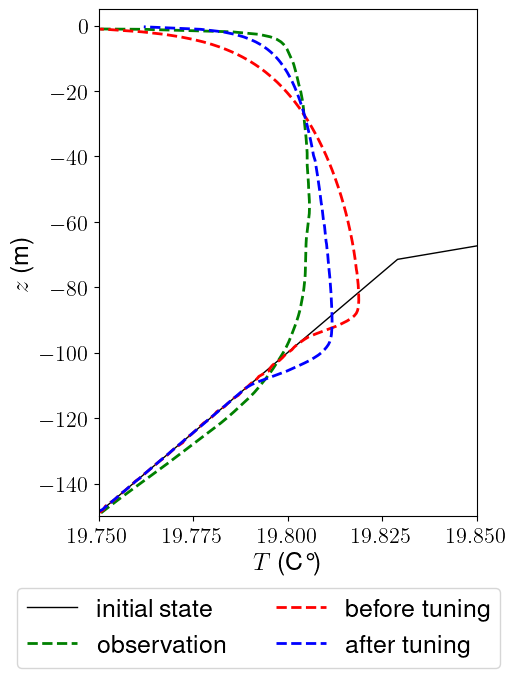

In [62]:

plt.rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica', size=18)

fig, ax = plt.subplots(figsize=(13*cm_inch, 18*cm_inch))
plt.tight_layout(rect=[0.05, 0.15,1., 1.])
zr = model.grid.zr

ax_leg.axis('off')
traj_wagner = traj_wagner_list[0]
traj_scm_init = traj_scm_init_list[0]
traj_scm_tuned = traj_scm_tuned_list[0]
l_i, = ax.plot(traj_wagner.t[0, :], zr, 'k', linewidth=1)
l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'g--', linewidth=2)
l_si, = ax.plot(traj_scm_init.t[-1, :], zr, 'r--', linewidth=2)
l_st, = ax.plot(traj_scm_tuned.t[-1, :], zr, 'b--', linewidth=2)
ax.set_ylabel(r'$z$ (m)', fontsize=18)
ax.set_xlabel(r'$T$ (C°)', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='both', labelsize=16)
    
ax.set_xlim([19.75, 19.85])
ax.set_ylim([-150, 5])

fig.legend([l_i, l_w, l_si, l_st], ['initial state', 'observation', 'before tuning', 'after tuning'], loc='lower center', ncol=2)

fig.show()

fig.savefig("calibrated.png", dpi=300, transparent=True)


# References
1. Wagner GL. et al. Formulation and calibration of CATKE, a one-equation parameterization for microscale ocean mixing. Journal of Advances in Modeling Earth Systems (submitted). 2024. https://arxiv.org/abs/2306.13204
2. Burchard, H., and K. Bolding. Comparative Analysis of Four Second-Moment Turbulence Closure Models for the Oceanic Mixed Layer. Journal of Physical Oceanography, 31, 1943–1968. 2001. https://doi.org/10.1175/1520-0485(2001)031<1943:CAOFSM>2.0.CO;2. 